<a href="https://colab.research.google.com/github/mmrepos/Chest_X_Ray_Images_Project/blob/main/Chest_X_Ray_Images_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark

In [6]:
!pip install tensorflow --ignore-installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.11.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached grpcio-1.51.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
  Using cached h5py-3.7.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.5 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached wrapt-1.14.1-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (81 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached numpy-1.23.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached termcolor-2.1.1-py3-none-any.whl (6.2 kB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached flatbuffers-22.11.23-py2.py3-none-any.whl (26 kB)
  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)
  Using cached setuptool

In [17]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import re
import os
import random
 
#TensorFlow
import tensorflow as tf
 
#keras
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Dropout
 
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
 
#Scikit
from sklearn.model_selection import train_test_split
 
 
#plot
from matplotlib import pyplot as plt


# pyspark
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType, IntegerType, ArrayType, FloatType
import pyspark.sql.functions as F
 
# PIL
from PIL import Image
 
# io
import io
 
%matplotlib inline

In [27]:
#List the contents of a Kaggle Dataset
for dirname, _, filenames in os.walk('/content/drive/MyDrive/chest-x-ray-images-preprocessing'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0003-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0009-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0011-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0015-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0007-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0005-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0011-0001-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0001-0001.jpeg
/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/NORMAL/IM-0016-0001.jpeg
/content/drive/MyDri

In [77]:
# Loading the Dataset
train_url = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/train/*/**.jpeg")
test_url = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/test/*/**.jpeg")
val_url = glob.glob(f"/content/drive/MyDrive/chest-x-ray-images-preprocessing/chest_xray/val/*/**.jpeg")

# Looking at the training, testing and validation data numbers
print(f"Training Set has: {len(train_url)} images")
print(f"Testing Set has: {len(test_url)} images")
print(f"Validation Set has: {len(val_url)} images")

Training Set has: 1869 images
Testing Set has: 624 images
Validation Set has: 16 images


# **Load DataFrames**

# **Model Creation**

# **Add label Transformer**
1. Adds a label column
2. Value of the label is 1 if the data is from pneumonia folder else 0 for normal xray

In [35]:
def add_label(img_origin: str):
    if "pneumonia" in img_origin.lower():
        return 1
    return 0

In [50]:
class AddLabel(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
        input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
        output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
 
  
        @keyword_only
        def __init__(self, input_col: str = "input", output_col: str = "output"):
            super(AddLabel, self).__init__()
            self._setDefault(input_col=None, output_col=None)
            kwargs = self._input_kwargs
            self.set_params(**kwargs)
 
        @keyword_only
        def set_params(self, input_col: str = "input", output_col: str = "output"):
            kwargs = self._input_kwargs
            self._set(**kwargs)
 
        def get_input_col(self):
            return self.getOrDefault(self.input_col)
 
        def get_output_col(self):
            return self.getOrDefault(self.output_col)
 
        def _transform(self, df: DataFrame):
            input_col = self.get_input_col()
            output_col = self.get_output_col()
            transform_udf = F.udf(add_label, IntegerType())
            return df.withColumn(output_col, transform_udf(input_col))

# **Image Process Transformer**
1. Adds a new features column
2. It resize the image
3. It converts the binary image into a vector

In [37]:
IMAGE_SIZE = [28, 28]
 
def decode_img(content):
    image = Image.open(io.BytesIO(content))
    im = image.resize(IMAGE_SIZE)
    arr = np.array(im)
    expanded_arr = arr[:, :, np.newaxis]
    # take array as an image then divide the pixel values by 255 to get 0-1 floats
    return (np.asarray(expanded_arr, dtype="float32") / 255 ).tolist()

In [38]:
class ImageDecoder(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
        input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
        output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
  
        @keyword_only
        def __init__(self, input_col: str = "input", output_col: str = "output"):
            super(ImageDecoder, self).__init__()
            self._setDefault(input_col=None, output_col=None)
            kwargs = self._input_kwargs
            self.set_params(**kwargs)
 
        @keyword_only
        def set_params(self, input_col: str = "input", output_col: str = "output"):
            kwargs = self._input_kwargs
            self._set(**kwargs)
 
        def get_input_col(self):
            return self.getOrDefault(self.input_col)
 
        def get_output_col(self):
            return self.getOrDefault(self.output_col)
 
        def _transform(self, df: DataFrame):
            input_col = self.get_input_col()
            output_col = self.get_output_col()
            transform_udf = F.udf(decode_img,ArrayType(ArrayType(ArrayType(FloatType()))))
            return df.withColumn(output_col, transform_udf(input_col))

# **Apply tansformations and Fit model**

In [39]:
val_df = spark.read.format("binaryFile").option("dropInvalid", True).load(val_url)
 
labeler = AddLabel(input_col="path", output_col="label")
val_df = labeler.transform(val_df)
decoder = ImageDecoder(input_col="content", output_col="features")
val_df = decoder.transform(val_df)

In [40]:
val_data = val_df.select('features').collect()
val_label = val_df.select('label').collect()

# **Example of transformed image**

In [42]:
display(val_df)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary, label: int, features: array<array<array<float>>>]

In [43]:
train_df = spark.read.format("binaryFile").option("dropInvalid", True).load(train_url)
 
labeler = AddLabel(input_col="path", output_col="label")
train_df = labeler.transform(train_df)
decoder = ImageDecoder(input_col="content", output_col="features")
train_df = decoder.transform(train_df).cache()

In [53]:
from pyspark.sql.functions import lit,unix_timestamp, udf, col, lit
from pyspark.sql.types import DoubleType, DecimalType
from pyspark.sql.functions import pandas_udf

def no_null_func(x):
    if np.any(x):
        return True
    return False
 
from pyspark.sql.types import BooleanType
no_null = udf(no_null_func, BooleanType())

In [54]:
filter_df = train_df.filter(no_null('features'))

In [55]:
filter_df.count()

1836

In [56]:
train_feature_data = filter_df.select('features').collect()

In [57]:
train_label_data = filter_df.select('label').collect()

In [58]:
train_feature = np.array(train_feature_data).reshape(-1, 28,28, 1)
train_labels = np.array(train_label_data)
 
validation_feature = np.array(val_data).reshape(-1, 28,28, 1)
validation_label = np.array(val_label)

# **Image Autoencoder**

In [59]:
x, y, z = 28, 28, 1 #input dimension l x w x d.  
image = Input(shape = (x, y, z))
 
def encoder(image):
    conv_block1 =  Conv2D(32, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(image) 
    maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv_block1)
    conv_block2 =  Conv2D(64, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(maxpool1)  
    maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv_block2)
    conv_block3 =  Conv2D(128, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(maxpool2) 
    conv_block4 =  Conv2D(256, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(conv_block3)  
    encode = conv_block4
    return encode
 
def decoder(encode):
    conv_dec1 = Conv2D(128, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(encode)  
    conv_dec2 = Conv2D(64, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(conv_dec1) 
    upsamp1 = UpSampling2D((2,2))(conv_dec2)
    conv_dec3 = Conv2D(32, (3, 3), activation='selu', padding='same',kernel_initializer='LecunNormal')(upsamp1)
    upsample2 = UpSampling2D((2,2))(conv_dec3) 
    decode = Conv2D(1, (3, 3), activation='sigmoid', padding='same',kernel_initializer='LecunNormal')(upsample2)
    return decode
 
img_autoencoder = Model(image, decoder(encoder(image)))
img_autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
img_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856 

In [60]:
batchSize = 128
epochs = 10
 
# UNSUPERVISED LEARNING
# autoencoder is trying to match itself from itself, which is why train_feature is both the feature and label
autoencoder_train = img_autoencoder.fit(train_feature, train_feature, batch_size=batchSize, epochs=epochs, verbose=1)
 
#Save the weights for the classifcation autoencoder
img_autoencoder.save_weights('img_autoencoder2.h5')

Epoch 1/10
15/15 [==============================] - 19s 1s/step - loss: 0.2344
Epoch 2/10
15/15 [==============================] - 18s 1s/step - loss: 0.1490
Epoch 3/10
15/15 [==============================] - 17s 1s/step - loss: 0.0406
Epoch 4/10
15/15 [==============================] - 17s 1s/step - loss: 0.0235
Epoch 5/10
15/15 [==============================] - 18s 1s/step - loss: 0.0356
Epoch 6/10
15/15 [==============================] - 17s 1s/step - loss: 0.0165
Epoch 7/10
15/15 [==============================] - 17s 1s/step - loss: 0.0285
Epoch 8/10
15/15 [==============================] - 17s 1s/step - loss: 0.0143
Epoch 9/10
15/15 [==============================] - 17s 1s/step - loss: 0.0164
Epoch 10/10
15/15 [==============================] - 17s 1s/step - loss: 0.0159


# **Test/Train Data Sorting/Filtering**

In [61]:
trainLabel_hot = to_categorical(train_labels.flatten())

In [62]:
test_df = spark.read.format("binaryFile").option("dropInvalid", True).load(test_url)
 
labeler = AddLabel(input_col="path", output_col="label")
test_df = labeler.transform(train_df)
decoder = ImageDecoder(input_col="content", output_col="features")
test_df = decoder.transform(train_df).cache()

In [63]:
filter_test_df = test_df.filter(no_null('features'))

In [64]:
test_feature_data = filter_test_df.select('features').collect()

In [65]:
test_label_data = filter_test_df.select('label').collect()

In [66]:
test_feature = np.array(test_feature_data).reshape(-1, 28,28, 1)
test_labels = np.array(test_label_data)

In [67]:
testLabel_hot = to_categorical(test_labels.flatten())

# **Classifcation Autoencoder**

Take the weights from the already trained img_autoencoder and pass it into a classifer which uses the weights from the img_autoencoder as a base.

The softmaxDense then acts as the classifier model

In [68]:
# Dense Layer with Softmax Layer for Classification of One-hot encoded Labels
num_classes = 2
def softmaxDense(autoencoder):
    flatlyer = Flatten()(autoencoder)
    denselyer = Dense(128, activation='selu')(flatlyer)
    softlyer = Dense(num_classes,activation='softmax')(denselyer)
    return softlyer
# take the ecoder from Image Autoecoder and combine with Softmax layer to detect One -hot encoded lables
autoencoder_classifer = Model(image,softmaxDense(encoder(image)))
autoencoder_classifer.summary()
 
#crude but effective way to pass the weights of the image enconder to the new encoder
autoencoder_classifer.layers[0].set_weights(img_autoencoder.layers[0].get_weights())
autoencoder_classifer.layers[1].set_weights(img_autoencoder.layers[1].get_weights())
autoencoder_classifer.layers[2].set_weights(img_autoencoder.layers[2].get_weights())
autoencoder_classifer.layers[3].set_weights(img_autoencoder.layers[3].get_weights())
autoencoder_classifer.layers[4].set_weights(img_autoencoder.layers[4].get_weights())
autoencoder_classifer.layers[5].set_weights(img_autoencoder.layers[5].get_weights())
autoencoder_classifer.layers[6].set_weights(img_autoencoder.layers[6].get_weights())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 128)         7385

In [69]:
#Compile the Autoencoder with Weights
autoencoder_classifer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon = 0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.FalseNegatives(),
                      tf.keras.metrics.FalsePositives(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),
                      tf.keras.metrics.AUC()])

In [70]:
ae_classiferTrain = autoencoder_classifer.fit(train_feature,trainLabel_hot,batch_size=batchSize,epochs=epochs)

Epoch 1/10
15/15 [==============================] - 10s 554ms/step - loss: 4.1440 - categorical_accuracy: 0.7092 - false_negatives: 534.0000 - false_positives: 534.0000 - precision: 0.7092 - recall: 0.7092 - auc: 0.7169
Epoch 2/10
15/15 [==============================] - 8s 555ms/step - loss: 2.1532 - categorical_accuracy: 0.6329 - false_negatives: 674.0000 - false_positives: 674.0000 - precision: 0.6329 - recall: 0.6329 - auc: 0.6982
Epoch 3/10
15/15 [==============================] - 8s 543ms/step - loss: 0.8494 - categorical_accuracy: 0.6743 - false_negatives: 598.0000 - false_positives: 598.0000 - precision: 0.6743 - recall: 0.6743 - auc: 0.7178
Epoch 4/10
15/15 [==============================] - 8s 544ms/step - loss: 0.5672 - categorical_accuracy: 0.7511 - false_negatives: 457.0000 - false_positives: 457.0000 - precision: 0.7511 - recall: 0.7511 - auc: 0.8067
Epoch 5/10
15/15 [==============================] - 9s 568ms/step - loss: 0.4128 - categorical_accuracy: 0.8355 - false_neg

In [72]:
# show available statistics
ae_classiferTrain.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'false_negatives', 'false_positives', 'precision', 'recall', 'auc'])

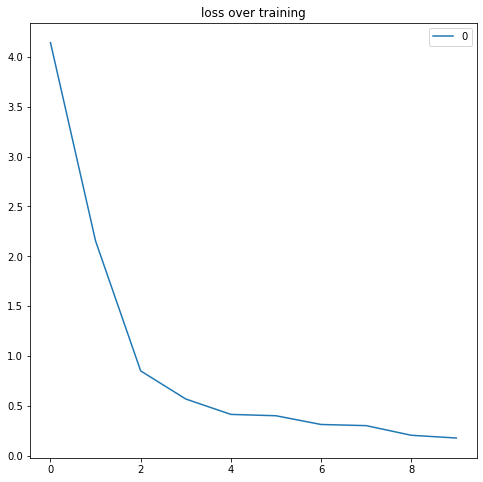

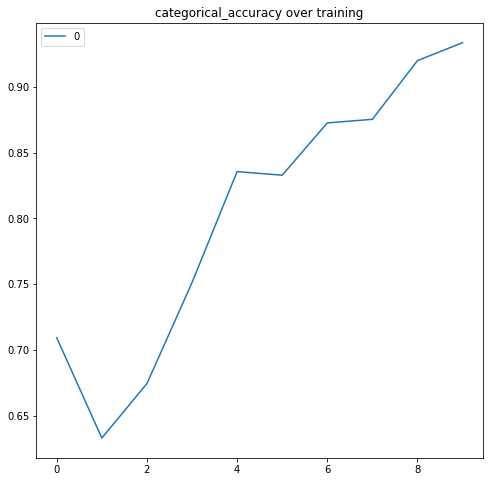

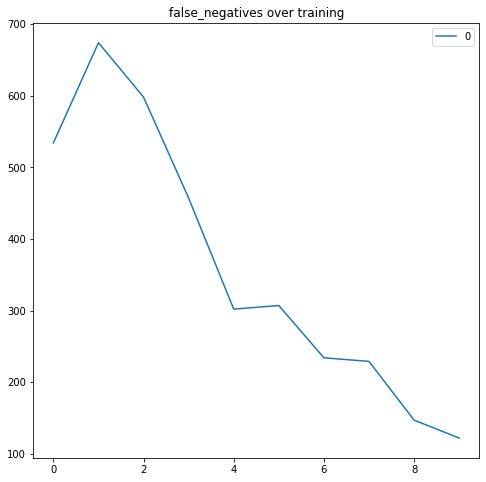

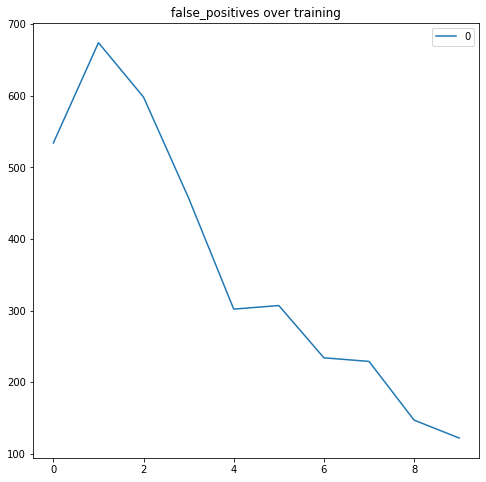

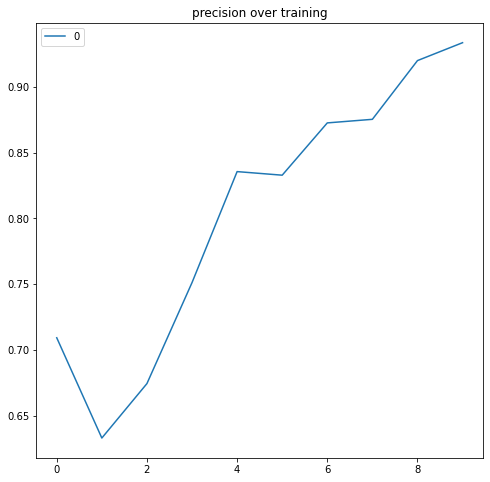

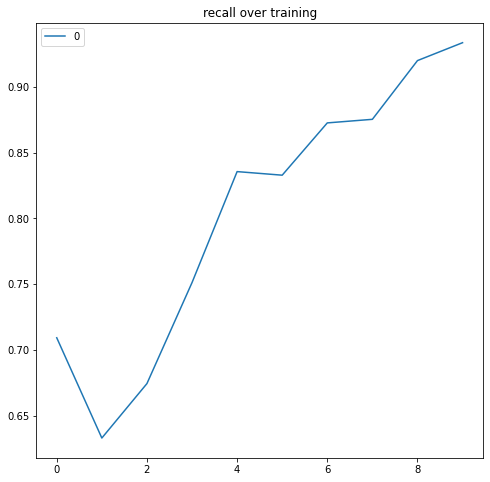

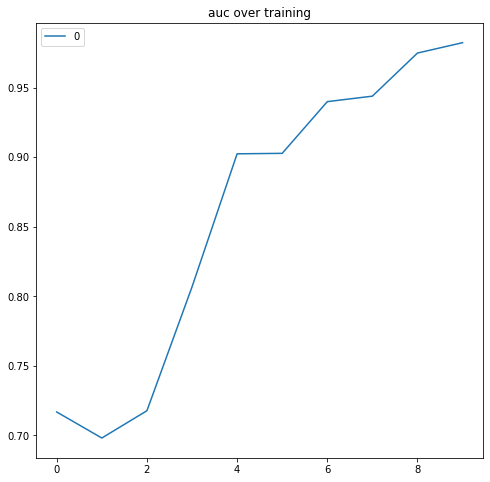

In [73]:
#plot recorded statistics
for stat in ae_classiferTrain.history.keys():
    pd.DataFrame(ae_classiferTrain.history[stat]).plot(figsize=(8,8), title='{} over training'.format(stat))

# **Testing**

Grabbing these statistics from the test classifier instead of the training data done above

In [74]:
score = autoencoder_classifer.evaluate(test_feature, testLabel_hot)

58/58 [==============================] - 5s 68ms/step - loss: 0.1716 - categorical_accuracy: 0.9248 - false_negatives: 138.0000 - false_positives: 138.0000 - precision: 0.9248 - recall: 0.9248 - auc: 0.9773


In [75]:
# Pretty print final recorded scores
print('Test Loss:             {:30f}'.format(score[0]))
print('Test Accuracy:         {:30f}'.format(score[1]))
print('Test False Negatives:  {:30f}'.format(score[2]))
print('Test False Positives:  {:30f}'.format(score[3]))
print('Test Precision:        {:30f}'.format(score[4]))
print('Test Recall:           {:30f}'.format(score[5]))
print('Test AUC:              {:30f}'.format(score[6]))

Test Loss:                                   0.171553
Test Accuracy:                               0.924837
Test False Negatives:                      138.000000
Test False Positives:                      138.000000
Test Precision:                              0.924837
Test Recall:                                 0.924837
Test AUC:                                    0.977264
